In [1]:
import pandas as pd
from lib.data_utils import *
from lib.model_utils import *
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import log_loss

import optuna

In [2]:
MODEL_TYPE = 'TYPE'
MODEL_NAME = f'LEMv3_MODEL_{MODEL_TYPE}_TORCH'

In [3]:
device = torch.device("cpu")

# Loading and Preprocessing Data

In [4]:
df_train, df_train_y, df_optimization, df_optimization_y, df_test, df_test_y, complete_feature_set, features_model = load_model_training_data_template(train_sets = ['data/wyscout/csv/events/Italy.csv', 'data/wyscout/csv/events/Germany.csv', 'data/wyscout/csv/events/France.csv'], optimization_sets = ['data/wyscout/csv/events/Italy.csv',], test_sets = ['data/wyscout/csv/events/Spain.csv', 'data/wyscout/csv/events/England.csv'])

In [5]:
print(list(df_train_y[MODEL_TYPE].columns))

['next_action_type_1', 'next_action_type_2', 'next_action_type_3', 'next_action_type_4', 'next_action_type_5', 'next_action_type_6', 'next_action_type_7', 'next_action_type_8', 'next_action_type_9', 'next_action_type_10', 'next_action_type_11', 'next_action_type_12', 'next_action_type_13', 'next_action_type_14', 'next_action_type_15', 'next_action_type_16', 'next_action_type_17', 'next_action_type_18', 'next_action_type_19', 'next_action_type_20', 'next_action_type_21', 'next_action_type_22', 'next_action_type_23', 'next_action_type_24', 'next_action_type_25', 'next_action_type_26', 'next_action_type_27', 'next_action_type_28', 'next_action_type_29', 'next_action_type_30', 'next_action_type_31', 'next_action_type_32', 'next_action_type_33']


In [6]:
features = features_model[MODEL_TYPE]
print(features)

['subtype_id_1', 'subtype_id_2', 'subtype_id_3', 'subtype_id_4', 'subtype_id_5', 'subtype_id_6', 'subtype_id_7', 'subtype_id_8', 'subtype_id_9', 'subtype_id_10', 'subtype_id_11', 'subtype_id_12', 'subtype_id_13', 'subtype_id_14', 'subtype_id_15', 'subtype_id_16', 'subtype_id_17', 'subtype_id_18', 'subtype_id_19', 'subtype_id_20', 'subtype_id_21', 'subtype_id_22', 'subtype_id_23', 'subtype_id_24', 'subtype_id_25', 'subtype_id_26', 'subtype_id_27', 'subtype_id_28', 'subtype_id_29', 'subtype_id_30', 'subtype_id_31', 'subtype_id_32', 'subtype_id_33', 'period', 'minute', 'x', 'y', 'is_home_team', 'accurate', 'goal', 'home_score', 'away_score']


In [7]:
X_train = df_train[features].astype(float).values
x_optimization = df_optimization[features].astype(float).values
X_test = df_test[features].astype(float).values

Y_train = df_train_y[MODEL_TYPE].astype(float).values
Y_optimization = df_optimization_y[MODEL_TYPE].astype(float).values
Y_test = df_test_y[MODEL_TYPE].astype(float).values

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_optimization_tensor = torch.tensor(x_optimization, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
Y_optimization_tensor = torch.tensor(Y_optimization, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

# Create datasets
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
optimization_dataset = TensorDataset(X_optimization_tensor, Y_optimization_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
optimization_dataloader = DataLoader(optimization_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

input_size = X_train.shape[1]
output_size = Y_train.shape[1]

# Tunning Model

In [8]:
ENABLE_TUNING = False
TUNNING_COMPLEXITY_PENALTY = 0.001
TUNNING_TRAIN_TEST_SPLIT = 0.7
TUNNING_N_TRIALS = 40

In [9]:
if ENABLE_TUNING:
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective(trial, X_optimization_tensor, Y_optimization_tensor, model_name=MODEL_NAME, train_test_split=TUNNING_TRAIN_TEST_SPLIT, complexity_penalty=TUNNING_COMPLEXITY_PENALTY), n_trials=TUNNING_N_TRIALS)

In [10]:
if ENABLE_TUNING:
    trial = study.best_trial
    print(trial.value, trial.params, trial.datetime_start, trial.datetime_complete)
    
    model = torch.load(f'models/lem/optuna_trials/{MODEL_NAME}_{trial.number}.pt')
    test_log_loss = evaluate_log_loss(model, optimization_dataloader, device)
    print(f'Test Log Loss: {test_log_loss:.4f}')

    plt.rcParams["figure.figsize"] = (20, 5)
    plt.subplot(121)
    probabilities = predict(model, X_optimization_tensor, device)
    plt.hist(probabilities, bins=50);
    plt.subplot(122)
    plt.hist(probabilities[:,1], bins=50, color='C1')
    plt.yscale('log');

# Train model

In [11]:
model = MultiLayerBinaryClassifier(input_size, [256], output_size, activation='sigmoid').to(device)
learning_rate = 0.001
num_epochs = 100
patience = 3
counter = 0
best_val_loss = 1000

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()

for epoch in range(num_epochs):
    train_loss = train(model, train_dataloader, criterion, optimizer, device)
    test_loss = evaluate(model, test_dataloader, criterion, device)
    test_log_loss = evaluate_log_loss(model, test_dataloader, device)
    print(f'Epoch: {epoch+1}/{num_epochs}.. Training loss: {train_loss:.4f}.. Test loss: {test_loss:.4f}.. Test Log Loss: {test_log_loss:.4f}')

    if test_log_loss < best_val_loss:
        best_val_loss = test_log_loss
        counter = 0
        torch.save(model, f'models/lem/{MODEL_NAME}.pth')
    else:
        counter += 1
        if counter >= patience:
            break

Epoch: 1/100.. Training loss: 0.0722.. Test loss: 0.0701.. Test Log Loss: 1.5525
Epoch: 2/100.. Training loss: 0.0693.. Test loss: 0.0693.. Test Log Loss: 1.5286
Epoch: 3/100.. Training loss: 0.0686.. Test loss: 0.0690.. Test Log Loss: 1.5194
Epoch: 4/100.. Training loss: 0.0684.. Test loss: 0.0687.. Test Log Loss: 1.5132
Epoch: 5/100.. Training loss: 0.0682.. Test loss: 0.0687.. Test Log Loss: 1.5113
Epoch: 6/100.. Training loss: 0.0681.. Test loss: 0.0687.. Test Log Loss: 1.5116
Epoch: 7/100.. Training loss: 0.0680.. Test loss: 0.0686.. Test Log Loss: 1.5082
Epoch: 8/100.. Training loss: 0.0680.. Test loss: 0.0685.. Test Log Loss: 1.5052
Epoch: 9/100.. Training loss: 0.0679.. Test loss: 0.0684.. Test Log Loss: 1.5044
Epoch: 10/100.. Training loss: 0.0679.. Test loss: 0.0685.. Test Log Loss: 1.5049
Epoch: 11/100.. Training loss: 0.0679.. Test loss: 0.0684.. Test Log Loss: 1.5037
Epoch: 12/100.. Training loss: 0.0678.. Test loss: 0.0684.. Test Log Loss: 1.5048
Epoch: 13/100.. Training 

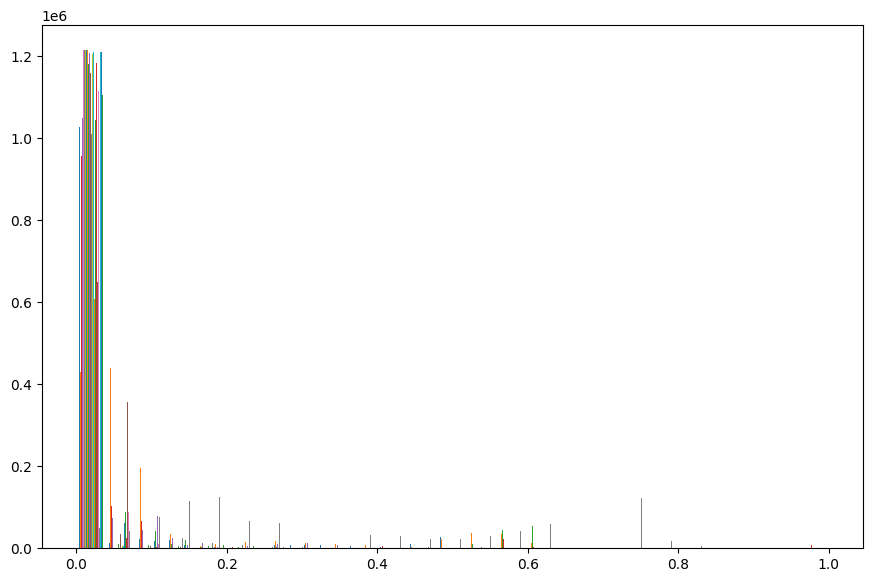

In [12]:
plt.rcParams["figure.figsize"] = (10.6, 6.8)
probabilities = predict(model, X_test_tensor, device)
plt.hist(probabilities, bins=25);